# Guía 1 - Análisis en el dominio del tiempo

Representamos una serie temporal de longitud $N$ por $\{x_t\} \equiv \{x_1, x_2, \ldots, x_N\}$.
* La serie temporal es una secuencia (ordenada) de variables aleatorias.  
* La serie temporal observada se considera una realización del modelo.  
* Contiene $N$ valores para tiempos discretos $1,2,\ldots,N$. Pueden ser:
    * muestras instantáneas (aproximadamente)
        * Temperatura a las 12:00hs, demanda eléctrica a las 12:00hs, etc.
    * agregados
        * temperatura media del día, consumo total diario, etc.
* $\hat{x}_{t+k|t}$ expresa una predicción o pronóstico hecha en el tiempo $t$ para un paso futuro $t+k$.
    * $k$ se conoce como el horizonte de pronóstico (*lead time*)

## Descomposición de series temporales

La serie temporal puede considerarse compuesta por diferentes términos. El modelo aditivo se expresa como

$$x_t = m_t + s_t + w_t$$

donde:
* $m_t$ representa la tendencia (los cambios en el largo plazo). Define un nivel o incremento.
* $s_t$ denota los factores estacionales. Captura la variación que ocurre cíclicamente sobre un período de tiempo: día-noche, estaciones, etc.
* $w_t$ El *residuo* es lo que queda de la serie temporal y no puede ser explicado por la tendencia y la estacionalidad. El residuo corresponde a los términos de error y, si es completamente al azar (ruido blanco), no puede ser modelado ni predecido.

![Representación de las componentes de una serie temporal](Figs/trend_season_error.png)

Si los efectos estacionales crecen con el tiempo, se prefiere un modelo multiplicativo

$$x_t = m_t \times s_t + w_t$$

o tomar logarítmos si la varianza del error crece con el tiempo.

Además, se suele hablar de *ciclos* para patrones que se repiten pero no son fijos. Por ejemplo, se mencionan los ciclos de auge y recesión en variables económicas. 

**Atención**: La serie aleatoria obtenida de la descomposición no es una realización del proceso aleatorio $X_t$ sino una estimación de su realización.  

__Estimación de la tendencia__: Un abordaje frecuente es el de *moving average* o ventana móvil que promedia los valores de un número específico de pasos (positivos y negativos) alrededor del tiempo $t$ definido. Otras alternativas incluyen regresiones sobre el conjunto completo de datos o por partes (*loess*).

__Estimación de los efectos estacionales__: se remueve primero la tendencia

$$\hat{s}_t = x_t - \hat{m}_t$$

y se promedian los efectos para cada mes (o intervalo conveniente). Usualmente, se substrae la media para que los efectos estacionales sumen cero.

En general, por construcción, estas técnicas no permiten extrapolar valores hacia el futuro (salvo regresión).

Buscamos extraer las componentes determinístcias $m_t$ y $s_t$ para quedarnos con una serie de tiempo residual y estacionaria. Esto se puede realizar por i) estimación de las componentes o ii) difrenciación de la serie ${X_t}$. 

### Series temporales estacionarias

Una serie temporal será estacionaria si su distribución de probabilidad no cambia al desplazarla en el tiempo. Entonces, una serie temporal estacionaria tendrá una media y varianza que no dependerán de $t$. 

En general, no contamos con diferentes realizaciones de una serie temporal. Se suele asumir que el promedio temporal calculado sobre una serie tiende al promedio del ensamble. Es decir, al valor que resultaría de promediar distintas realizaciones de las variables estocásticas que forman la serie. Por ejemplo, para la media notamos que

$$\lim_{N \rightarrow \infty} \sum_{t=0}^{N} \frac{x_t}{N} = \mu$$

donde $\mu$ no depende de $t$. 

Por ejemplo, si la serie temporal presenta tendencia entonces no será estacionaria (la media cambia con el tiempo. 

*La descomposición de la serie busca que el término de error sea estacionario.* Esto quiere decir que podremos derivar valores futuros como función de los valores pasados dado que los coeficientes no cambiarán con el tiempo, haciendo el pronóstico confiable.

### Aproximación general al modelado de series temporales

Para modelar una serie temporal se pueden tener en cuenta los siguientes pasos:

* Representar la serie y examinar los principales atributos
* Chequear la presencia de
  - Tendencias
  - Estacionalidad
  - cambios de comportamiento
  - datos faltantes y *outliers*
* Remover las componentes para quedarse con la serie temporal residual
* Transformar los valores si se observa que la varianza cambia con el tiempo, por ejemplo, introduciendo logaritmos.

## Métodos en Python disponibles para descomponer una serie temporal

Presentaremos métodos disponibles en Python que facilitan la descomposición y análisis de una serie temporal. Lo desarrollaremos tomando de ejemplo la serie de demanda electrica diaria provista por Cammesa (ver Guía 0). Comenzaremos cargando la base de datos y agregando un índice de tiempo.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

baseDiaria = pd.read_excel('Data/Base Demanda Diaria 2017 2025.xlsx', sheet_name='Datos Región', skiprows=4)
baseDiaria.head()


,AÑO,MES,Fecha,Tipo día,GRAN BS.AS.,BUENOS AIRES,CENTRO,LITORAL,CUYO,NOROESTE,NORESTE,COMAHUE,PATAGONICA,DEMANDA TOTAL,TEMPERATURA REFERENCIA MEDIA GBA °C
0,2017,2017-01-01,2017-01-01,Domingo o Feriado,6352.695208,1472.270500,1134.394250,1766.623958,903.135875,1602.126625,1400.333417,561.243208,500.863042,15693.686083,31.30
1,2017,2017-01-01,2017-01-02,Lunes habiles,6617.863750,1779.435208,1363.527292,1963.925833,1091.811167,1627.567250,1585.616708,638.835167,540.577750,17209.160125,25.35
2,2017,2017-01-01,2017-01-03,Martes Habiles,6677.996167,1888.984333,1600.744625,2036.345917,1178.718583,1806.474000,1652.989833,624.649083,536.472333,18003.374875,25.45
3,2017,2017-01-01,2017-01-04,Miercoles habiles,6426.997625,1840.623833,1356.381292,1756.640500,1078.903250,1759.855667,1604.750375,598.400500,528.904083,16951.457125,27.00
4,2017,2017-01-01,2017-01-05,Jueves Habiles,5873.950750,1770.942583,1366.018917,1848.409375,1037.791833,1403.490042,1228.303125,585.206708,524.657125,15638.770458,21.90


In [2]:
baseDiaria.set_index(pd.to_datetime(baseDiaria['Fecha']),inplace=True)
baseDiaria = baseDiaria[['DEMANDA TOTAL', 'Tipo día', 'TEMPERATURA REFERENCIA MEDIA GBA °C']]
baseDiaria.rename(columns={'TEMPERATURA REFERENCIA MEDIA GBA °C':'TEMP MEDIA'}, inplace=True)
baseDiaria['Interval'] = np.float32((baseDiaria.index - baseDiaria.index[0]).days)

Realizamos una representación para recordar como varía la variable `DEMANDA TOTAL` con el tiempo.

Text(0, 0.5, 'DEMANDA TOTAL (MW)')

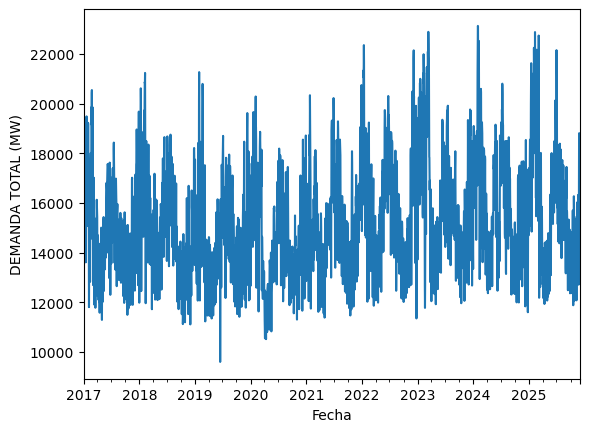

In [3]:
baseDiaria['DEMANDA TOTAL'].plot()
plt.ylabel('DEMANDA TOTAL (MW)')

Notamos una suave tendencia de aumento de la demanda y un claro comportamiento estacional: máximos en verano e invierno y mínimos en otoño y primavera. Esto sugiere una vinculación fuerte con la temperatura

### Descomposición de la serie temporal de DEMANDA TOTAL

Introducimos la función `seasonal_decompose` del paquete `statsmodels.tsa.seasonal` que realiza la descomposición de la serie en tendencia, efectos estacionales y residuo.

Text(0.5, 23.52222222222222, 'Year')

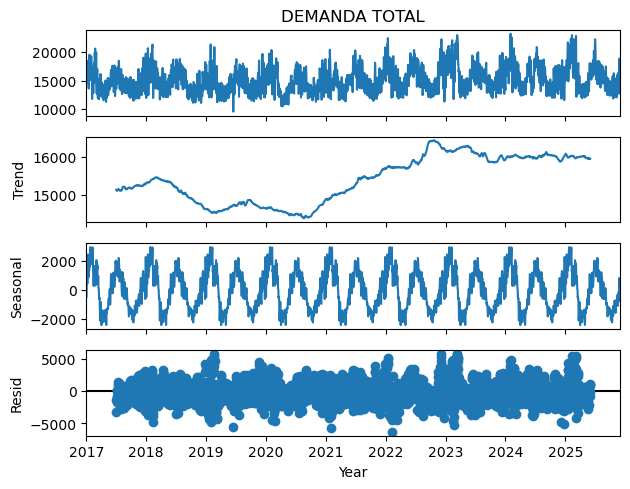

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
period = 365 #setting the period for decomposition
# Apply seasonal_decompose
result_sd = seasonal_decompose(baseDiaria['DEMANDA TOTAL'], model='additive', period=period, extrapolate_trend=0)
# Plot the results
# plot_components(result_sd)
# or
result_sd.plot();
#plt.gca().set_xticks(np.arange(0,3000,365),np.arange(0,9))
plt.gca().set_xlabel('Year')

La tendencia muestra un aumento hacia mayores demandas eléctricas con el paso del tiempo. Si bien hay una baja alrededor de 2020 (interpretación trivial), la evolución es hacia mayores demandas como se espera de un crecimiento general de la sociedad. Los efectos estacionales muestran dos picos de consumo por año. Finalmente, nos interesa que el residuo represente a una variable estocástica estacionaria. 

### Augmeneted Dickey Fuller Test

La prueba Dickey-Fuller aumentada (ADF) es una prueba estadística en el análisis de series de tiempo que se utiliza para determinar si una serie de tiempo dada es estacionaria.

La estacionariedad garantiza que el rendimiento del modelo sea consistente a lo largo del tiempo. Los datos no estacionarios pueden generar pronósticos engañosos e inferencias incorrectas. Por ello, uno de los primeros pasos en el análisis de series temporales es comprobar la estacionariedad.

Hipótesis Nula y Alternativa:

* Hipótesis Nula (H₀): La serie tiene raíz unitaria (La presencia de una raíz unitaria significa que la serie no es estacionaria).
* Hipótesis Alternativa (H₁): La serie es estacionaria.

In [5]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(result_sd.resid[period:-period])
print(f'ADF Statistic: {ADF_result[0]:.3f}')
print(f'p-value: {ADF_result[1]:.3e}')

print("Critical Values:")
for key, value in ADF_result[4].items():
    print(f"   {key}: {value:.3f}")

ADF Statistic: -7.538
p-value: 3.437e-11
Critical Values:
   1%: -3.433
   5%: -2.863
   10%: -2.567


Como el ADF Statistic (-7.53) es menor que el valor crítico (-3.43 para el 1%), y el p-value es muy pequeño, la serie es muy probablemente estacionaria.

## Ejercicios

1. Realizar la descomposición de la serie de `DEMANDA TOTAL` a partir de sus diferencias `baseDiaria['DEMANDA TOTAL'].diff()` con el día anterior. Realizar el test de Dickey Fuller aumentada para el término de error. ¿Qué conclusiones se destacan? 
2. Realizar la descomposición de la serie de `DEMANDA TOTAL` a partir de sus diferencias `baseDiaria['DEMANDA TOTAL'].diff(365)` con el año anterior. Realizar el test de Dickey Fuller aumentada para el término de error. ¿Qué conclusiones se destacan?
3. Hallar la tendencia para la serie de `DEMANDA TOTAL` a aprtir de una regresión lineal en función del tiempo (desde el inicio de la serie).
4. Realizar la descomposición de la serie de temperaturas máximas para la estación meteorológica de Castelar. Realizar el test de Dickey Fuller aumentada para el término de error. ¿Qué conclusiones se destacan? 

## Correlaciones 

Luego de remover la tendencia y los factores estacionales, suelen permanecer correlaciones entre variables sucesivas del término de error. 

Recordamos, la covarianza es una medida de la asociación lineal entre 2 variables. Una estimación de la covarianza de la *muestra* es

$$\mathrm{Cov}(x, y) = \frac{1}{N-1} \sum (x_i - \bar{x})(y_i - \bar{y})$$

Además,

$$\mathrm{Var}(x) = \mathrm{Cov}(x,x) = \mathrm{sd}^2(x)$$

La **correlación** es una medida adimensional de la asociación lineal entre 2 variables. La correlación de la *muestra* es

$$\mathrm{Cor}(x,y) = \frac{\mathrm{Cov}(x, y)}{\mathrm{sd}(x)\mathrm{sd}(y)}$$

**Atención**: El hallazgo de correlaciones altas no implica causalidad. Se deben buscar mecanismos explicativos (ver [Spurious correlations](https://www.tylervigen.com/spurious-correlations)).

 ### Autocorrelaciones

Además de la media y la varianza, la autocorrelación es crucial en el estudio de modelos de series temporales. La autocorrelación mide la relación lineal entre la serie temporal y sus valores retrasados o en pasos de tiempo anteriores. En lo siguiente, asumimos que las funciones solo dependen del número de pasos que separa a las variables (*estacionariedad de segundo orden*). 

La función de autocovarianza (acvf) de una serie temporal se puede estimar por 

$$\mathrm{acvf}_k = \frac{1}{N} \sum_{t=1}^{N-k} (x_t - \bar{x})(x_{t+k} - \bar{x})$$

Notamos que $\mathrm{acvf}_0$ equivale a $\mathrm{Var}(x)$ con denominador $N$. 

Luego, la función de autocorrelación (acf) se expresa por

$$\mathrm{acf}_k = \frac{\mathrm{acvf}_k}{\mathrm{acvf}_0}$$

### Correlograma

El correlograma es una representación de acf en función de k (*lag*). En otros palabra, muestra cuánto del valor actual de la serie depende de sus valores pasados.

### Autocorrelación parcial

La autocorrelación parcial remueve la influencia de los pasos intermedios, proporcionando una visión clara y directa de la relación entre una varibale y sus valores pasados. A deifencia de la autocorrelación, la autocorrelación parcial se enfoca en la correlación directa para cada paso.

La función de autocorrelación parcial (PACF) en el lag $k$ es 

$$\mathrm{pacf}_{k,k} = \frac{ \mathrm{Cov}\left(x_t, x_{t+k} | x_{t+1}, \ldots, x_{t+k-1} \right) }{\sqrt{\mathrm{Var}\left(x_t| x_{t+1}, \ldots, x_{t+k-1} \right)  \mathrm{Var}\left(x_{t+k}| x_{t+1}, \ldots, x_{t+k-1} \right)}}$$

con 
* $\mathrm{Cov}\left(x_t, x_{t+k} | x_{t+1}, \ldots, x_{t+k-1} \right)$ es la covarianza condicional entre $x_t$ y $x_{t+k}$ dados los valores de los pasos intermedios (lags).
* $\mathrm{Var}\left(x_t | x_{t+1}, \ldots, x_{t+k-1} \right)$ es la varianza condicional de $x_t$ dados los valores de los pasos intermedios (lags).
* $\mathrm{Var}\left(x_{t+k} | x_{t+1}, \ldots, x_{t+k-1} \right)$ es la varianza condicional de $x_{t+k}$ dados los valores de los pasos intermedios (lags).


En otras palabras, dada una serie ${x_t}$, la autocorrelación parcial de retraso (lag) $k$ es la autocorrelación entre $x_t$ y $x_{t+k}$ donde las dependencias lineales de $x_t$ en los apsos intermedios $x_{t+1}, \ldots, x_{t+k-1}$ fueron removidos (en general sería, la correlación entre X and Y con los efectos lineales de Z removidos).



## Métodos en Python disponibles para el cálculo y representación de autocorrelaciones

Ejemplificamos la representación en un correlograma para el término de error luego de la descomposición de la `DEMANDA TOTAL` Si bien el cálculo de las autocorrelaciones puede realizarse con el método `acf()` del paquete `statsmodels.tsa.stattools`, se suele usar el método `plot_acf()` del paquete `statsmodels.graphics.tsaplots` que realiza simultáneamente el cálculo y el gráfico de la función acf.


Text(0.5, 0, 'Lag')

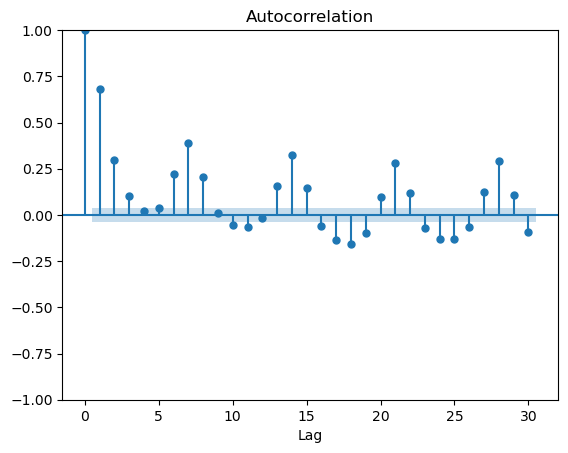

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(result_sd.resid[period:-period], lags=30, bartlett_confint=False)
plt.xlabel('Lag')
# Se ven los efectos semanales

Observaciones:

* Por definición de la función acf, el lag 0 siempre vale 1. Se deja para fijar el tamaño de la escala ya que el eje de las ordenadas es adimensional.
* Si no hubiera autocorrelaciones, $\mathrm{acf}_k$ tendería a 0 con varianza $1/N$.
* Esto conduce a reconocer que si $\mathrm{acf}_k=0$, aún un 5% de las estimaciones caerán por fuera de las líneas $\pm 2/\sqrt{N}$.
* Por default, se calcula la fórmula de Barlett que genera errores como si fuera un proceso *moving averge*. Por este motivo, definimos `bartlett_confint=False` para que las franjas de error se ubiquen en $\pm 2/\sqrt{N}$.

Además:
* Una tendencia se suele ver en el correlograma como una autocorrelación que decae lentamente.
* Si hay efectos estacionales se manifiestan como picos del correlograma.

Particularmente:
* El correlograma de `DEMANDA TOTAL` muestra picos con lags múltiplos de 7. Se espera ver estos picos ya que no removimos los efectos semanales.
* 

## Ejercicios

1. Obtener el correlograma para la serie de `DEMANDA TOTAL` previo a su descomposición. ¿Qué conclusiones se extraen?
2. Obtener el correlograma para la diferencia a un día de la serie de `DEMANDA TOTAL`. ¿Qué conclusiones se extraen?
3. Obtener el correlograma para la diferencia a 365 días de la serie de `DEMANDA TOTAL`. ¿Qué conclusiones se extraen?
4. Obtener el correlograma para la serie de temperaturas máximas de la estación Castelar, y para su término de error leugo de la descomposición de la serie. ¿Qué conclusiones se extraen?
5. ¿Cómo sería la autocorrelación de un proceso $x_t = c * t$?¿Cómo sería la autocorrelación de un proceso $x_t = \cos(2*\pi*t/T)$?

## Métodos en Python disponibles para el cálculo y representación de autocorrelaciones parciales

Ejemplificamos la representación en un correlograma parcial para el término de error luego de la descomposición de la `DEMANDA TOTAL` Si bien el cálculo de las autocorrelaciones parciales puede realizarse con el método `pacf()` del paquete `statsmodels.tsa.stattools`, se suele usar el método `plot_pacf()` del paquete `statsmodels.graphics.tsaplots` que realiza simultáneamente el cálculo y el gráfico de la función pacf.

Text(0.5, 0, 'Lag')

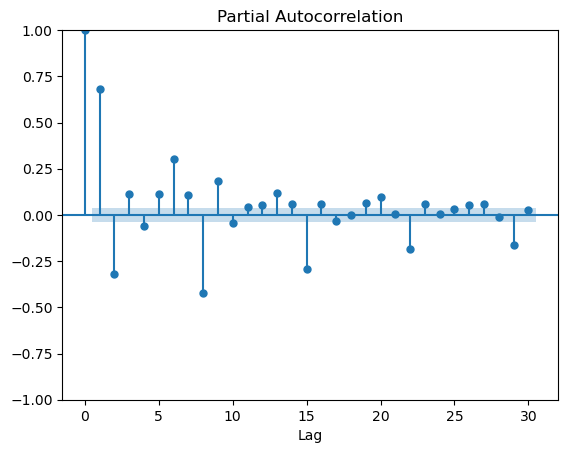

In [7]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(result_sd.resid[period:-period], lags=30)
plt.xlabel('Lag')
# Se ven los efectos semanales

## Ejercicios

1. Obtener la función PACF para para la serie de temperaturas máximas de la estación Castelar, y para su término de error luego de la descomposición de la serie. ¿Qué conclusiones se extraen?
2. Importar el conjunto de datos de manchas solares disponibles desde la biblioteca `statsmodels.api`.  


    import statsmodels.api as sm  
    dta = sm.datasets.sunspots.load_pandas().data  
    dta.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))  
    del dta["YEAR"]  
  
Representar la autocorrelación y la autocorrelación parcial. ¿Cómo se interpreta que luego del lag 10 la autocorrelación parcial sea menor que el error estimado?


## Correlaciones cruzadas

Las correlaciones cruzadas son las correlaciones presentes entre dos o más series temporales. Asumimos que las correlaciones solo dependen del lag entre variables por lo que el modelo combinado es estacionario de segundo orden.

Por su definción la función de correlación cruzada (ccf) no es simétrica

$$\mathrm{ccf}_k(x,y) = \mathrm{ccf}_{-k}(y,x)$$

Si $x$ es la entrada a un sistema físico y $y$ es la respuesta entonces, como la causa debe preceder al efecto, $y$ debe retrasar (tener un lag) respecto a $x$. En otras palabras, $\mathrm{ccf}_k(x,y)$ debe ser cero para $k$ positivos y mostrar algunos picos en $k$ negativos. Las correlaciones cruzadas nos permiten descubrir variables que anticipan el comportamiento de otra serie y pueden ser usadas para pronosticar.

## Estimación con python de correlaciones cruzadas

Realizaremos un ejemplo de cálculo de correlación cruzada entre las series de tiempo para inflación y desempleo en Estados Unidos. Los datos son de libre acceso desde el portal del Grupo Banco Mundial ([Indicadores](https://datos.bancomundial.org/indicador)). Las series cubren desde 1960 hasta 2024.

In [8]:
usa_ec = pd.read_csv('Data/USA_inflation_unemployment.csv')

In [9]:
usa_ec.set_index(pd.to_datetime(usa_ec['Year'], format='%Y'),inplace=True)
usa_ec.drop(columns='Year', inplace=True)
usa_ec.rename(columns={'FP.CPI.TOTL.ZG': 'Inflación', 'SL.UEM.TOTL.NE.ZS':'Desempleo'}, inplace=True)


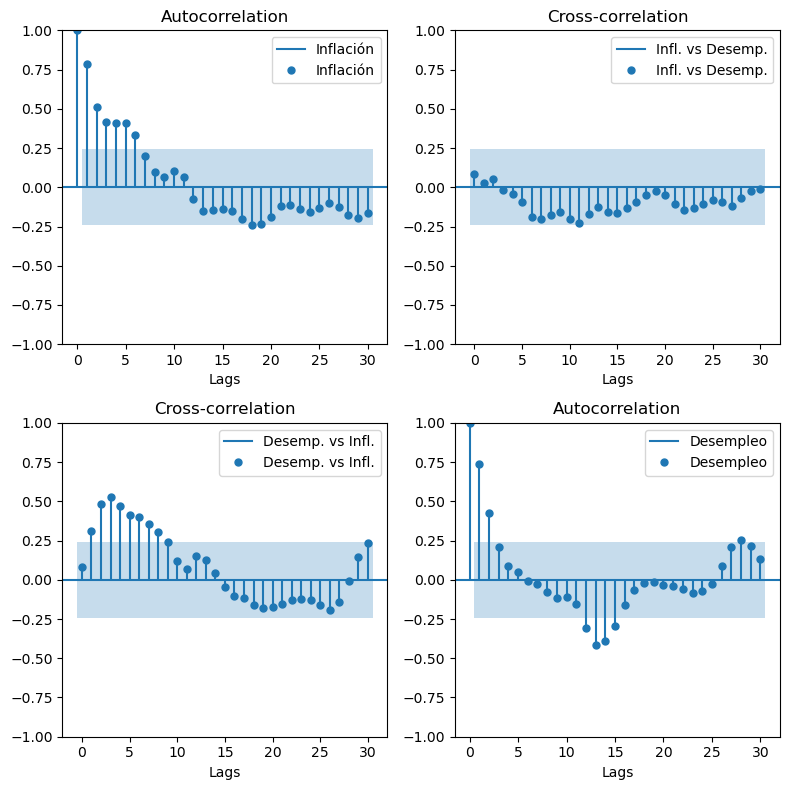

In [10]:
from statsmodels.graphics.tsaplots import plot_ccf

fig, axs = plt.subplots(2,2, figsize=(8,8))

plot_acf(usa_ec['Inflación'], lags=30, bartlett_confint=False, ax=axs[0,0], label='Inflación')
axs[0,0].set_xlabel('Lags')
axs[0,0].legend(loc='best')
plot_ccf(usa_ec['Inflación'], usa_ec['Desempleo'], lags=30, ax=axs[0,1], label='Infl. vs Desemp.')
axs[0,1].set_xlabel('Lags')
axs[0,1].legend(loc='best')
plot_ccf(usa_ec['Desempleo'], usa_ec['Inflación'], lags=30, ax=axs[1,0], label='Desemp. vs Infl.')
axs[1,0].set_xlabel('Lags')
axs[1,0].legend(loc='best')
plot_acf(usa_ec['Desempleo'], lags=30, bartlett_confint=False, ax=axs[1,1], label='Desempleo')
axs[1,1].set_xlabel('Lags')
axs[1,1].legend(loc='best')
plt.tight_layout()

En egenral, se suele representar en un mismo gráfico las correlaciones cruzadas tanto para lags positivos como negativos.

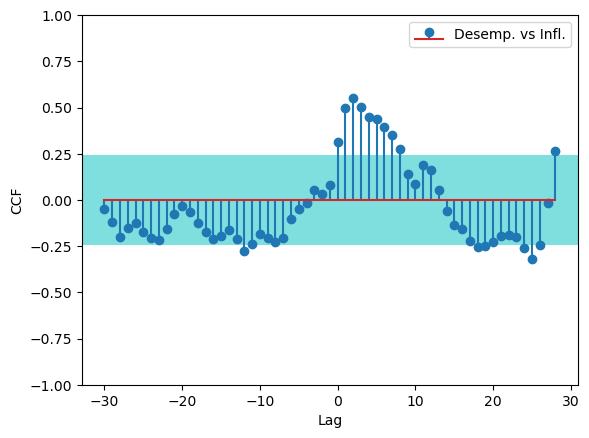

In [11]:
from statsmodels.tsa.stattools import ccf

backwards = ccf(usa_ec['Inflación'], usa_ec['Desempleo'], nlags=30)[::-1]
forwards = ccf(usa_ec['Desempleo'], usa_ec['Inflación'], nlags=30)
ccf_output = np.r_[backwards[:-1], forwards]
plt.stem(range(-len(ccf_output)//2, len(ccf_output)//2), ccf_output, label='Desemp. vs Infl.')
plt.ylim(-1,1)
plt.xlabel('Lag')
plt.ylabel('CCF')
# 95% UCL / LCL

plt.axhspan(-1.96/np.sqrt(len(usa_ec['Inflación'])), 1.96/np.sqrt(len(usa_ec['Inflación'])), facecolor='c', alpha=0.5)
plt.legend(loc='best')

Es importante notar que el desempleo responde con un máximo aproximadamente después de 3 años de la inflación. Por otro lado, como es de esperar, el desempleo está descorrelacionado con la inflación para lags negativos (respuesta causal). 

## Ejercicios

1. Estudiar, si corresponde, la correlación cruzada para los datos de inflación y desempleo en Estados Unidos removiendo previamente de las series las tendencias y la estacionalidad.
2. Estudiar la correlación cruzada entre las series de `DEMANDA TOTAL` y `TEMPERATURA REFERENCIA MEDIA GBA °C`. ¿Cómo afecta a la correlación cruzada que la demanda eléctrica crezca tanto para temperaturas muy bajas como muy altas?